In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from typing import List, Tuple
import matplotlib.pyplot as plt

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import confusion_matrix
import itertools

## training set, validation set, testing set

In [2]:
train_set = pd.read_csv('train_set_V.csv')[:100000]
test_set = pd.read_csv('test_set_V.csv')[:10000]

In [3]:
y_train = np.array(train_set['TARGET'])
x_train = np.array(train_set.drop(['TARGET'], axis=1))

y_test = np.array(test_set['TARGET'])
x_test = np.array(test_set.drop(['TARGET'], axis=1))

In [4]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(100000, 202) (100000,)
(10000, 202) (10000,)


# Grid search

In [5]:
from typing import List, Tuple

def cross_validation(X: np.ndarray, y: np.ndarray, k: int) -> List[Tuple[np.ndarray, np.ndarray, 
                                                                         np.ndarray, np.ndarray]]:  
    n = int(len(X)/k )+1   # number of elements in each group
    subsets_X = []
    subsets_y = []
    
    for i in range(k-1):
        subsets_X.append(X[i*n: (i+1)*n])
        subsets_y.append(y[i*n: (i+1)*n])
    
    subsets_X.append(X [(k-1)*n:])
    subsets_y.append(y [(k-1)*n:])
    tuples_to_return = []
    
    for i in range(k):
        indexes = np.arange(k)
        train_indexes = (np.delete(indexes, i)).astype(int)
        train_data =  np.vstack([subsets_X[j] for j in train_indexes ])
        train_labels =  np.hstack([ subsets_y[j] for j in train_indexes] )     
        test_data = np.array(subsets_X[i])
        test_labels = np.array(subsets_y[i])                
        tuples_to_return.append( (train_data, train_labels, test_data, test_labels)  )
        
    return tuples_to_return

In [6]:
def find_best_params_Poly(datasets):
    
    C_list = list(map(lambda x : 10**(x), [-3,-2,-1,0,1,2]))
    degree_list = list(map(lambda x : x, [1,2]))
    coef_list = list(map(lambda x : x, [-10, -1, 0, 0.1, 1, 10]))
    gamma_list = list(map(lambda x : 10**(-x), [0,1,2,3]))

    scores = []
    
    for C in C_list:
        for gamma in gamma_list:
            for coef in coef_list:
                for degree in degree_list:
                    
                    val_accuracy = []
                    for dataset in datasets:
                        svm = SVC(kernel = 'poly', C = C, degree = degree)
                        svm.fit(dataset[0], dataset[1])
                        val_acc = svm.score(dataset[2], dataset[3])
                        val_accuracy.append(val_acc)

                    scores.append( (C, gamma, np.mean(val_accuracy) ) )
                    print("C = ",C, "degree:", degree, "coef ", coef, "gamma ", gamma, "accuracy:", np.mean(val_accuracy), len(val_accuracy))
       
    argmax= np.argmax(scores, axis = 0)[2]
    print("\n\nPoly: accuracy: {:} for C = {:}, gamma  = {:}".format( scores[argmax][2],scores[argmax][0],scores[argmax][1])  )
    

In [7]:
def find_best_params_rbf(datasets):
    
    C_list = list(map(lambda x : 10**(x), [-3,-2,-1,0,1,2]))
    gamma_list = list(map(lambda x : 10**(-x), [0,1,2,3]))
    coef_list = list(map(lambda x : x, [-10, -1, 0, 0.1, 1, 10]))

    scores = []
    
    for coef in coef_list:
        for C in C_list:
            for gamma in gamma_list:
                val_accuracy = []

                for dataset in datasets:
                    svm = SVC(kernel = 'rbf', C = C, gamma=gamma, coef0 = coef)
                    svm.fit(dataset[0], dataset[1])
                    val_acc = svm.score(dataset[2], dataset[3])
                    val_accuracy.append(val_acc)

                scores.append( (C, gamma, coef, np.mean(val_accuracy) ) )
                #print("C = ", C, "gamma", gamma, "mean accuracy:", np.mean(val_accuracy), len(val_accuracy))

    argmax= np.argmax(scores, axis = 0)[3]
    print("rbf: accuracy: {:} for C = {:}, gamma  = {:}, coef = {:}".format( scores[argmax][3],scores[argmax][0],scores[argmax][1], scores[argmax][2])  )
 

In [8]:
def find_best_params_linear(datasets):

    C_list = list(map(lambda x : 10**(x), [-3,-2,-1,0,1,2,3]))
    gamma_list = list(map(lambda x : 10**(-x), [0,1,2,3]))
    coef_list = list(map(lambda x : x, [-10, -1, 0, 0.1, 1, 10]))
    scores = []
    
    for coef in coef_list:
        for C in C_list:  
            for gamma in gamma_list:

                val_accuracy = []
                for dataset in datasets:
                    svm = SVC(kernel = 'linear', C = C, gamma=gamma,  coef0 = coef)
                    svm.fit(dataset[0], dataset[1])
                    val_acc = svm.score(dataset[2], dataset[3])
                    val_accuracy.append(val_acc)

                scores.append( (C,gamma,coef,np.mean(val_accuracy) ) )
                #print("C = ", C, "gamma", gamma, "mean accuracy:", np.mean(val_accuracy), len(val_accuracy))
    
    argmax= np.argmax(scores, axis = 0)[3]
    print("linear: accuracy: {:} for C = {:}, gamma= {:} coef = {:}".format( scores[argmax][3],scores[argmax][0], scores[argmax][1],  scores[argmax][2],   )  )

In [9]:
def find_best_params_sigmoid(datasets):
       
    C_list = list(map(lambda x : 10**(x), [-6,-5,-4,-3,-2,-1,0,1,2]))
    scores = []
    
    for C in C_list:
        val_accuracy = []
        for dataset in datasets:
            svm = SVC(kernel ='sigmoid', C = C)
            svm.fit(dataset[0], dataset[1])
            val_acc = svm.score(dataset[2], dataset[3])
            val_accuracy.append(val_acc)

            scores.append( (C, np.mean(val_accuracy) ) )
            #print("C = ", C, "mean accuracy:", np.mean(val_accuracy), "len", len(val_accuracy))

    argmax= np.argmax(scores, axis = 0)[1]
    print("sigmoid: accuracy: {:} for C = {:}".format( scores[argmax][1], scores[argmax][0],   )  )

# Grid search using different kernels:

In [10]:
#datasets = cross_validation(x_train, y_train, k= 3)
#for dataset in datasets:       
#    datasets_val = cross_validation(dataset[0], dataset[1], k= 3)
#    find_best_params_sigmoid(datasets_val)

In [11]:
#for dataset in datasets:       
#    datasets_val = cross_validation(dataset[0], dataset[1], k= 3)
#    find_best_params_Poly(datasets_val)

In [12]:
#for dataset in datasets:       
#    datasets_val = cross_validation(dataset[0], dataset[1], k= 3)
#    find_best_params_rbf(datasets_val) 

In [13]:
#for dataset in datasets:       
#    datasets_val = cross_validation(dataset[0], dataset[1], k= 3)
#    find_best_params_linear(datasets_val)

## Evaluate the model with best params:

In [14]:
SVC_rbf = SVC(kernel ='rbf', C = 0.001, gamma =  0.1, coef0 = -10)
SVC_rbf.fit(x_train, y_train)
accuracy = SVC_rbf.score(x_test, y_test)
print("RBF kernel, accuracy on test set = {:}".format(accuracy))  ## updated

RBF kernel, accuracy on test set = 0.8264


In [15]:
SVC_sigmoid = SVC(kernel ='sigmoid', C = 1e-5)
SVC_sigmoid.fit(x_train, y_train)
accuracy = SVC_sigmoid.score(x_test, y_test)
print("Sigmoid kernel, accuracy on test set = {:}".format(accuracy))

Sigmoid kernel, accuracy on test set = 0.8264


In [16]:
SVC_linear = SVC(kernel ='linear', C = 0.1,  gamma =  0.1)
SVC_linear.fit(x_train, y_train)
accuracy = SVC_linear.score(x_test, y_test)
print("Linear kernel, accuracy on test set = {:}".format(accuracy))

Linear kernel, accuracy on test set = 0.8409


# Best model: final evaluation

In [25]:
output = SVC_linear.predict(x_train)
target = y_train
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on train set: {:.2f} %".format(accuracy*100))

output = SVC_linear.predict(x_test)
target = y_test
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on testing set: {:.2f} %".format(accuracy*100))


Accuracy on train set: 83.64 %

Accuracy on testing set: 84.09 %


recall: 0.09331797235023041
precision: 0.9050279329608939


Text(0.5, 13.421126458070283, 'Predicted label')

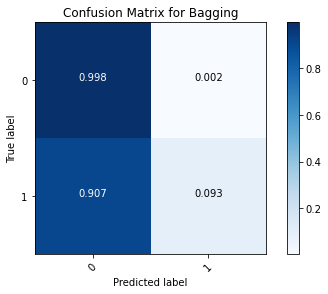

In [26]:
classes = [0,1]
y_true = y_test
y_pred = output #SVC_rbf(x_test)
cm = confusion_matrix(y_true, y_pred, normalize ='true')


print("recall:", recall_score(y_true, y_pred ))
print("precision:", precision_score(y_true, y_pred ))

plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix for Bagging")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],3), horizontalalignment="center", color="white" if cm[i, j] > 0.5 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label') 

In [29]:
output = SVC_sigmoid.predict(x_train)
target = y_train
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on train set: {:.2f} %".format(accuracy*100))

output = SVC_sigmoid.predict(x_test)
target = y_test
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on testing set: {:.2f} %".format(accuracy*100))


Accuracy on train set: 82.45 %

Accuracy on testing set: 82.64 %


recall: 0.0
precision: 0.0


Text(0.5, 13.421126458070283, 'Predicted label')

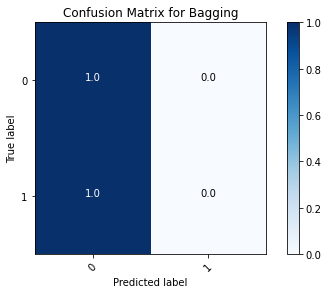

In [30]:
classes = [0,1]
y_true = y_test
y_pred = output #SVC_rbf(x_test)
cm = confusion_matrix(y_true, y_pred, normalize ='true')


print("recall:", recall_score(y_true, y_pred ))
print("precision:", precision_score(y_true, y_pred ))

plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix for Bagging")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],3), horizontalalignment="center", color="white" if cm[i, j] > 0.5 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label') 